## Multi-agent reinforcement learning

<small>see sections 1.1 to 1.4 and 5.2 to 5.4 of [Multi-Agent Reinforcement Learning: Foundations and Modern Approaches](https://www.marl-book.com) for a more in-depth overview. Consider watching this [YouTube video](https://www.youtube.com/watch?v=QfYx5q0Q75M) by the book's author which provides a great introduction.</small>

So far we tackled the problem of learning an optimal policy for a single agent inside a MDP, we now shift our focus towards contexts in which there are _multiple_ agents acting in the MDP with (possibly) different goals.

For example, consider a fleet of autonomous vehicles with the goal of driving as quickly and safely as possible, a team of players in a competitive videogame or a group of automated traders that manage each their own investments in a public market.

How does the addition of other learning agents change what we learned so far?

_See the available [environments](https://pettingzoo.farama.org/environments/classic/) from the PettinZoo library for more examples_

A **multi-agent system** is composed of an environment and multiple decision-making agents, also called _players_, that interact in the environment to achieve certain goals. The environment evolves during play according the player's actions and optionally randomness. 

**Multi-agent reinforcement learning** or **MARL** tackles learning in such systems by building algorithm that let the players refine their respective strategies, which can be collaborative, competitive or a mix of the two. 

At the start of a round of the game, each player sees the state of the environment and picks an action, the round ends after every player has chosen an action, then the envoriment evolves accordingly and each player collects their reward to update their respective policy.

From the point of view of the agent, little has changed, they still have a set of actions, a policy, an enviroment and the goal of optimizing their policy.
What changed?

The difference lies in the fact that **the immediate reward achieved by any player depends on the actions of the other players on the same round**.

For example consider a group of learning agents playing football, when a goal is scored, the success is tied to the actions of all the players, not only of the player that last kicked the ball. This introduces the problem of understanding how much of each player contributed, this is called **multi-agent credit assignment**.

Another issue that arises in MARL is the dependence on the number of agents, when considering games with a thousands of players, our learning procedure by struggle. When dealing with multiple agents, the algorithms will need to scale well with the number of agents.

### The goal of multi-agent reinforcement learning
In the classic RL case, a policy is optimal if it maximises the _return_, defined as the sum of the immediate reward obtained during play, in the multi-agent case, any player's return depends on the other players' actions and ultimately depends on their policies.

**If the return of a policy depends on the other policies, how do we define optimality?** There is no fixed answer to this question, in fact it depends on the underlying context and the objective of the learning procedure, for now we only focus on modeling the problem. To understand the different solutions concepts for MARL we will rely on game-theorical arguments.

In the meantime, we can evaluate the performance of a learning algorithm by its convergence rate to a specific solution concept, viz. we define a specific policy for each player to which we want our algorithm to converge to and we try to understand
1. If the learning algorithm converges to the proposed solution (which the algorithm does not know).
2. If true, how fast is the convergence?

For example, going back to the football example, before the start of the game we decide _roughly_ how we want the players to play by defining different roles, which translate to different behaviours. Afterward we pick a learning algorithm and try to understand if the players actually learn to play as we intended.

This might seem very accidental, how can we be sure that the algorithm will converge to these behaviours that we randomly picked? This can be achieved by choosing these behaviours wisely from very well studied solution concepts, which we will tackle in the next lesson.

### Welcome to the PettingZoo
The Farama foundation, who maintains the Gymnasium library, work also on a MARL-oriented library called [PettingZoo](https://pettingzoo.farama.org/). They share the same interface, which is very useful when, hypothetically, you have been following a course using Gym and now you need to abruptly switch library to cover MARL topics.

Now a couple of examples

In [1]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

def visualize(render):
	clear_output(wait=True)
	plt.imshow(render)
	plt.show()

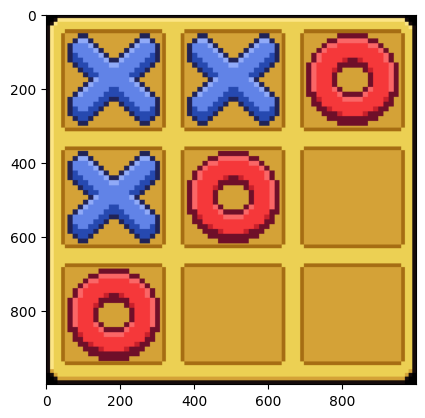

In [ ]:
from pettingzoo.classic import tictactoe_v3

env = tictactoe_v3.env(render_mode = "rgb_array")
env.reset(seed = 42)

for agent in env.agent_iter():
	observation, reward, termination, truncation, info = env.last()
	if termination or truncation:
		action = None
	else:
		# Sample only legal moves
		legal_moves = observation["action_mask"]
		action = env.action_space(agent).sample(legal_moves)

	visualize(env.render())
	env.step(action)

env.close()

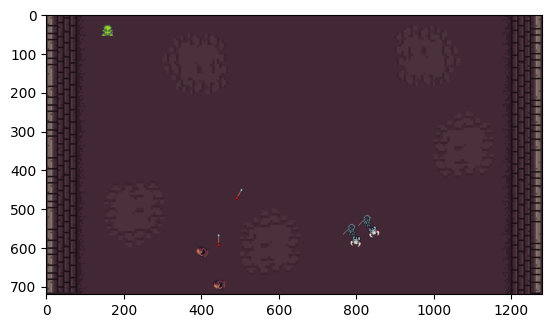

In [3]:
from pettingzoo.butterfly import knights_archers_zombies_v10

env = knights_archers_zombies_v10.env(render_mode = "rgb_array")
env.reset(seed = 42)

for agent in env.agent_iter(max_iter = 100):
	observation, reward, termination, truncation, info = env.last()
	action = env.action_space(agent).sample()

	visualize(env.render())
	env.step(action)

env.close()

### A bit for formality
We now introduce the notation necessary to formalize the proposed multi-agent systems. Little has changed from the MDPs in RL, we simply need to add multiple players and tweak the reward function.

#### Markov decision processes

First recall that a Markov decision process (MDP) is defined as a tuple of
- Finite set of states $\mathcal{S}$
- Finite set of actions $\mathcal{A}$
- Reward function $r: \mathcal{S} \times \mathcal{A} \to \mathbb{R}$
- State transition probability function $\{ p(\cdot \mid s, a) \mid s \in \mathcal{S}, a \in \mathcal{A} \}$ defined on a transition kernel $p(\cdot \mid s, a)$ over $\mathcal{S}$.

For simplicity, the reward function does not vary with time and the state and action sets are finite.

#### Stochastic games

Now onto the multi-agent case, what changed? First of all call $N \in \mathbb{N}$ the number of players and $I = \{ 1, \dots, N \}$. The set of actions $\mathcal{A}$ now contains groups of actions, one for each player. The reward function is also changed, not only now depends on the actions of all the players, we can also assume that it can change from player to player (which translates into players with different objectives). Formally we define this model as a tuple of
- Finite set of players $I = \{ 1, \dots, N \}$
- Finite set of states $\mathcal{S}$
- For each player $i \in I$
	- Finite set of actions $\mathcal{A}_i$
	- Reward function $r_i: \mathcal{S} \times \mathcal{A} \to \mathbb{R}$ where $\mathcal{A} := \mathcal{A}_1 \times \dots \times \mathcal{A}_N$
- State transition probability function $\{ p(\cdot \mid s, a) \mid s \in \mathcal{S}, a \in \mathcal{A} \}$ defined on a transition kernel $p(\cdot \mid s, a)$ over $\mathcal{S}$.

This model takes the name of **Stochastic game** or **Shapley game**, sometimes it is also called Markov game (even though Markov has nothing to do with it).